# Multi-agent Trajectory Planning

These examples demonstrate the use of RxInfer for trajectory planning in multi-agent situations. The animations show the inferred trajectories from probabilistic inference.
The examples shown in this notebook are based on https://github.com/biaslab/MultiAgentTrajectoryPlanning/blob/main/door.jl, prepared by [Michi-Tsubaki](https://github.com/Michi-Tsubaki), extended by [bvdmitri](https://github.com/bvdmitri). The original code is a part of the paper [Multi-Agent Trajectory Planning with NUV Priors](https://ieeexplore.ieee.org/document/10645034) by Bart van Erp.

## Introduction

This notebook demonstrates multi-agent trajectory planning using probabilistic inference with RxInfer.jl. In this example, we model multiple agents navigating through an environment with obstacles while trying to reach their respective goals. The planning problem is formulated as Bayesian inference, where:

- Agent states evolve according to linear dynamics
- Collision avoidance between agents and obstacles is encoded as probabilistic constraints
- Goal-seeking behavior is represented as prior distributions

By performing inference on this probabilistic model, we can compute optimal trajectories that balance goal-reaching with collision avoidance. The visualization shows how agents coordinate their movements to navigate efficiently through the environment.


In [1]:
using LinearAlgebra, RxInfer, Plots, LogExpFunctions, StableRNGs

## Environment setup

To test our ideas, we need an environment to work with. We are going to create a simple environment consisting of a plane with boxes as obstacles. These boxes can be placed anywhere we want on the plane, allowing us to experiment with different configurations and scenarios. This flexible setup will help us evaluate how our multi-agent trajectory planning algorithms perform under various conditions and obstacle arrangements.

In [2]:
# A simple struct to represent a rectangle, which is defined by its center (x, y) and size (width, height)
Base.@kwdef struct Rectangle
    center::Tuple{Float64, Float64}
    size::Tuple{Float64, Float64}
end

function plot_rectangle!(p, rect::Rectangle)
    # Calculate the x-coordinates of the four corners
    x_coords = rect.center[1] .+ rect.size[1]/2 * [-1, 1, 1, -1, -1]
    # Calculate the y-coordinates of the four corners
    y_coords = rect.center[2] .+ rect.size[2]/2 * [-1, -1, 1, 1, -1]
    
    # Plot the rectangle with a black fill
    plot!(p, Shape(x_coords, y_coords), 
          label = "", 
          color = :black, 
          alpha = 0.5,
          linewidth = 1.5,
          fillalpha = 0.3)
end

# A simple struct to represent an environment, which is defined by a list of obctales,
# and in this demo the obstacles are just rectangles
Base.@kwdef struct Environment
    obstacles::Vector{Rectangle}
end

function plot_environment!(p, env::Environment)
    for obstacle in env.obstacles
        plot_rectangle!(p, obstacle)
    end
    return p
end

function plot_environment(env::Environment)
    p = plot(size = (800, 400), xlims = (-20, 20), ylims = (-20, 20), aspect_ratio = :equal)
    plot_environment!(p, env)
    return p
end

plot_environment (generic function with 1 method)

In the code above, we've defined two key structures for our environment:

1. `Rectangle`: A simple structure representing rectangular obstacles, defined by:
   - `center`: The (x,y) coordinates of the rectangle's center
   - `size`: The (width, height) of the rectangle
2. `Environment`: A structure that contains a collection of obstacles (rectangles)

We've also defined several plotting functions:
- `plot_rectangle!`: Adds a rectangle to an existing plot
- `plot_environment!`: Adds all obstacles in an environment to an existing plot
- `plot_environment`: Creates a new plot and displays the environment

These structures and functions provide the foundation for visualizing our 2D environment
where multi-agent trajectory planning will take place.

Let's create a couple of different environments to demonstrate multi-agent trajectory planning. You can experiment with different obstacle configurations by modifying the rectangle positions, sizes, and quantities. This will allow you to test how the agents navigate around various obstacle arrangements and interact with each other in different scenarios.




## Door environment

In this environment, we'll create a scenario resembling a doorway that agents must navigate through. The environment will consist of two wall-like obstacles with a narrow passage between them, simulating a door or gateway. This setup will test the agents' ability to coordinate when passing through a constrained space, which is a common challenge in multi-agent path planning. The narrow passage will force agents to negotiate the right-of-way and potentially wait for each other to pass through, demonstrating emergent cooperative behaviors.

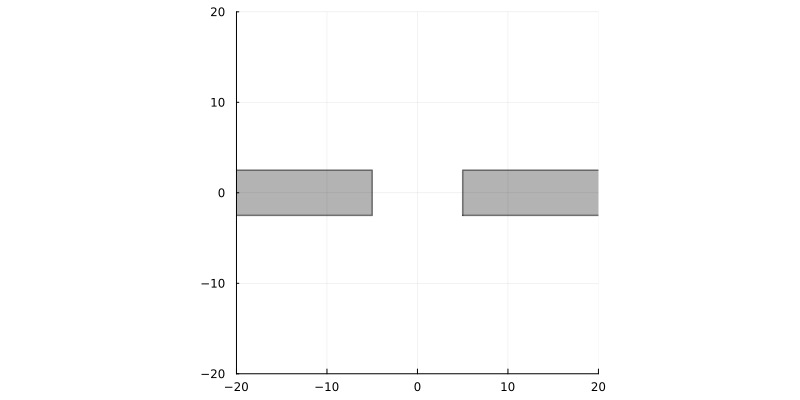

In [3]:
door_environment = Environment(obstacles = [
    Rectangle(center = (-40, 0), size = (70, 5)),
    Rectangle(center = (40, 0), size = (70, 5))
])

plot_environment(door_environment)

# Wall environment

In this environment, we'll create a scenario with a wall in the center that agents must navigate around. The environment will consist of a single elongated obstacle positioned in the middle of the space, forcing agents to choose whether to go above or below the wall. This setup will test the agents' ability to find efficient paths around obstacles and coordinate with each other to avoid congestion on either side of the wall. It represents a common scenario in multi-agent navigation where agents must make decisions about which route to take when faced with a barrier.

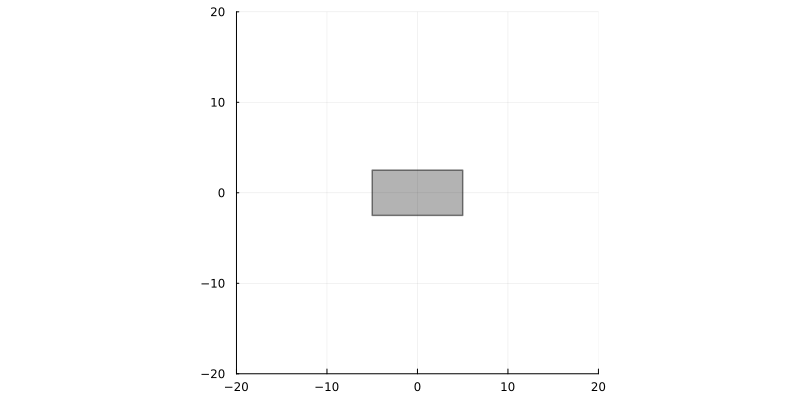

In [4]:
wall_environment = Environment(obstacles = [
    Rectangle(center = (0, 0), size = (10, 5))
])

plot_environment(wall_environment)

# Combined environment

In this environment, we'll combine the door and wall scenarios to create a more complex navigation challenge. This environment will feature both a narrow doorway that agents must pass through and a wall obstacle they need to navigate around. This combined setup will test the agents' ability to handle multiple types of obstacles in sequence, requiring more sophisticated path planning and coordination. Agents will need to negotiate the doorway and then decide which path to take around the wall, or vice versa depending on their starting and goal positions. This represents a more realistic scenario where environments often contain various types of obstacles that require different navigation strategies.


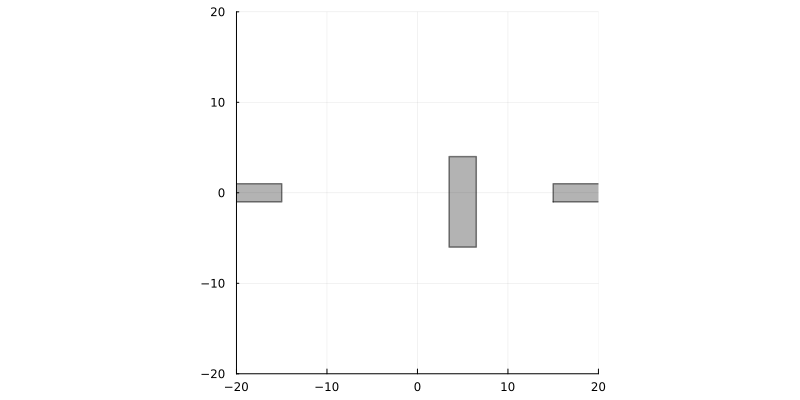

In [5]:
combined_environment = Environment(obstacles = [
    Rectangle(center = (-50, 0), size = (70, 2)),
    Rectangle(center = (50, -0), size = (70, 2)),
    Rectangle(center = (5, -1), size = (3, 10))
])

plot_environment(combined_environment)

# Agent state

In this section, we define states and goals for our agents. Each agent has a initial position and target end position. These states will be used to drive agent movement through the environment. The trajectory planning algorithm will use this information to generate paths from start to destination while avoiding obstacles. We start by first defining the necessary structures and functions for the goals.


In [6]:

# Agent plan, encodes start and goal states
Base.@kwdef struct Agent
    radius::Float64
    initial_position::Tuple{Float64, Float64}
    target_position::Tuple{Float64, Float64}
end

function plot_marker_at_position!(p, radius, position; color="red", markersize=10.0, alpha=1.0, label="")
    # Draw the agent as a circle with the given radius
    θ = range(0, 2π, 100)
    
    x_coords = position[1] .+ radius .* cos.(θ)
    y_coords = position[2] .+ radius .* sin.(θ)
    
    plot!(p, Shape(x_coords, y_coords); color=color, label=label, alpha=alpha)
    return p
end

plot_marker_at_position! (generic function with 1 method)

Let see how does one of configurations for a single agent might look like in the first door environment. For this we will use two agents with different radius, as well as different initial and taget positions.

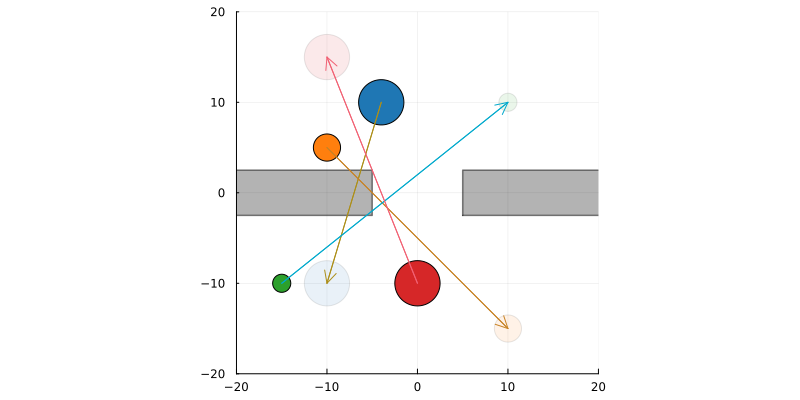

In [7]:
function plot_agent_naive_plan!(p, agent; color = "blue")
    plot_marker_at_position!(p, agent.radius, agent.initial_position, color = color)
    plot_marker_at_position!(p, agent.radius, agent.target_position, color = color, alpha = 0.1)
    quiver!(p, [ agent.initial_position[1] ], [ agent.initial_position[2] ], quiver = ([ agent.target_position[1] - agent.initial_position[1] ], [ agent.target_position[2] -  agent.initial_position[2] ]))
end

let pe = plot_environment(door_environment)
    agents = [ 
        Agent(radius = 2.5, initial_position = (-4, 10), target_position = (-10, -10)),
        Agent(radius = 1.5, initial_position = (-10, 5), target_position = (10, -15)),
        Agent(radius = 1.0, initial_position = (-15, -10), target_position = (10, 10)),
        Agent(radius = 2.5, initial_position = (0, -10), target_position = (-10, 15))
    ]
    
    colors = Plots.palette(:tab10)
    
    for (k, agent) in enumerate(agents)
        plot_agent_naive_plan!(pe, agent, color = colors[k])
    end
    
    pe
end

The plot above illustrates that naive trajectory from initial to target position will obviously not work and the agents will hit either the wall or each other while trying to execute their plan. Thus we need to come up with a better plan and simultaneously take into account multiple agents in the same environment.

## Next Steps

Now that we have set up our environment, defined our agents, and created utility functions, we are ready to build an RxInfer model to solve this multi-agent trajectory planning problem. In the following sections, we will:

1. Define a probabilistic model that captures the dynamics of our agents
2. Incorporate collision avoidance constraints between agents and obstacles using NUV priors
3. Use message passing to infer optimal trajectories
4. Visualize the resulting paths

This will demonstrate how probabilistic programming with RxInfer can elegantly solve complex planning problems while handling uncertainty and constraints in a principled way.


### Half space prior implementation

For our multi-agent trajectory planning model, we need to implement half-space priors to handle collision avoidance constraints. These priors allow us to model the requirement that agents must stay outside of obstacles and maintain safe distances from each other. The mathematical details and theoretical foundation of these half-space priors can be found in the paper referenced at the beginning of this notebook. The implementation below defines the necessary node and message-passing rules for incorporating these constraints into our probabilistic model.


In [8]:
# Define the probabilistic model for obstacles using halfspace constraints
struct Halfspace end

@node Halfspace Stochastic [out, a, σ2, γ]

# rule specification
@rule Halfspace(:out, Marginalisation) (q_a::Any, q_σ2::Any, q_γ::Any) = begin
    return NormalMeanVariance(mean(q_a) + mean(q_γ) * mean(q_σ2), mean(q_σ2))
end

@rule Halfspace(:σ2, Marginalisation) (q_out::Any, q_a::Any, q_γ::Any, ) = begin
    # `BayesBase.TerminalProdArgument` is used to ensure that the result of the posterior computation is equal to this value
    return BayesBase.TerminalProdArgument(PointMass( 1 / mean(q_γ) * sqrt(abs2(mean(q_out) - mean(q_a)) + var(q_out))))
end

### Distance functions for collision avoidance

In addition to the halfspace priors, we need to implement distance functions to properly handle collision avoidance between agents and obstacles. These functions will calculate the distance between agents and obstacles, which is essential for determining when collision avoidance constraints should be activated. The distance functions will be used to ensure that agents maintain safe distances from each other and from obstacles in the environment. In the next section, we'll define utility functions that include these distance calculations for different geometric shapes like rectangles and circles.


In [9]:
softmin(x; l=10) = -logsumexp(-l .* x) / l

# state here is a 4-dimensional vector [x, y, vx, vy]
function distance(r::Rectangle, state)
    if abs(state[1] - r.center[1]) > r.size[1] / 2 || abs(state[2] - r.center[2]) > r.size[2] / 2
        # outside of rectangle
        dx = max(abs(state[1] - r.center[1]) - r.size[1] / 2, 0)
        dy = max(abs(state[2] - r.center[2]) - r.size[2] / 2, 0)
        return sqrt(dx^2 + dy^2)
    else
        # inside rectangle
        return max(abs(state[1] - r.center[1]) - r.size[1] / 2, abs(state[2] - r.center[2]) - r.size[2] / 2)
    end
end

function distance(env::Environment, state)
    return softmin([distance(obstacle, state) for obstacle in env.obstacles])
end

distance (generic function with 2 methods)

We use the `softmin` function to create a smooth approximation of the minimum distance between an agent and multiple obstacles. Unlike the regular `min` function which returns the exact minimum value, `softmin` produces a differentiable approximation that considers all distances with a weighted average, heavily biased toward the smallest values.

The parameter `l` controls the "sharpness" of the approximation - with larger values making the function behave more like the true minimum. This smoothness is particularly valuable in optimization contexts as it:

1. Avoids discontinuities that could cause numerical issues during inference
2. Provides gradient information from all obstacles, not just the closest one
3. Creates a more stable optimization landscape for trajectory planning

When calculating the distance between an agent and the environment, `softmin` helps create a continuous repulsive field around all obstacles, allowing for more natural avoidance behaviors.


## Model specification

We use RxInfer's `@model` macro to specify the model. In the current example we fix our model to exactly 4 agents to simplify the model creation and construction. We also define auxiliary functions `g` and `h` which computes distance with agent's radius offset and minimum distance between all agents pairwise.

In [10]:
# Helper function, distance with radius offset
function g(environment, radius, state)
    return distance(environment, state) - radius
end

# Helper function, finds minimum distances between agents pairwise
function h(environment, radiuses, states...)
    # Calculate pairwise distances between all agents
    distances = Real[]
    n = length(states)

    for i in 1:n
        for j in (i+1):n
            push!(distances, norm(states[i] - states[j]) - radiuses[i] - radiuses[j])
        end
    end

    return softmin(distances)
end

h (generic function with 1 method)

In [11]:
# For more details about the model, please refer to the original paper
@model function path_planning_model(environment, agents, goals, nr_steps)

    # Model's parameters are fixed, refer to the original 
    # paper's implementation for more details about these parameters
    local dt = 1
    local A  = [1 dt 0 0; 0 1 0 0; 0 0 1 dt; 0 0 0 1]
    local B  = [0 0; dt 0; 0 0; 0 dt]
    local C  = [1 0 0 0; 0 0 1 0]
    local γ  = 1

    local control
    local state
    local path   
    
    # Extract radiuses of each agent in a separate collection
    local rs = map((a) -> a.radius, agents)

    # Model is fixed for 4 agents
    for k in 1:4

        # Prior on state, the state structure is 4 dimensional, where
        # [ x_position, x_velocity, y_position, y_velocity ]
        state[k, 1] ~ MvNormal(mean = zeros(4), covariance = 1e2I)

        for t in 1:nr_steps

            # Prior on controls
            control[k, t] ~ MvNormal(mean = zeros(2), covariance = 1e-1I)

            # State transition
            state[k, t+1] ~ A * state[k, t] + B * control[k, t]

            # Path model, the path structure is 2 dimensional, where 
            # [ x_position, y_position ]
            path[k, t] ~ C * state[k, t+1]

            # Environmental distance
            zσ2[k, t] ~ GammaShapeRate(3 / 2, γ^2 / 2)
            z[k, t]   ~ g(environment, rs[k], path[k, t])
            
            # Halfspase priors were defined previousle in this experiment
            z[k, t] ~ Halfspace(0, zσ2[k, t], γ)

        end

        # goal priors (indexing reverse due to definition)
        goals[1, k] ~ MvNormal(mean = state[k, 1], covariance = 1e-5I)
        goals[2, k] ~ MvNormal(mean = state[k, nr_steps+1], covariance = 1e-5I)

    end

    for t = 1:nr_steps

        # observation constraint
        dσ2[t] ~ GammaShapeRate(3 / 2, γ^2 / 2)
        d[t] ~ h(environment, rs, path[1, t], path[2, t], path[3, t], path[4, t])
        d[t] ~ Halfspace(0, dσ2[t], γ)

    end

end

@constraints function path_planning_constraints()
    # Mean-field variational constraints on the parameters
    q(d, dσ2) = q(d)q(dσ2)
    q(z, zσ2) = q(z)q(zσ2)
end

path_planning_constraints (generic function with 1 method)

## Constraint specification

In [12]:
function path_planning(; environment, agents, nr_iterations = 350, nr_steps = 40, seed = 42)
    # Fixed number of agents
    nr_agents = 4

    # Form goals compatible with the model
    goals = hcat(
        map(agents) do agent
            return [
                [ agent.initial_position[1], 0, agent.initial_position[2], 0 ],
                [ agent.target_position[1], 0, agent.target_position[2], 0 ]
            ]
        end...
    )
    
    rng = StableRNG(seed)
    
    # Initialize variables, more details about initialization 
    # can be found in the original paper
    init = @initialization begin

        q(dσ2) = repeat([PointMass(1)], nr_steps)
        q(zσ2) = repeat([PointMass(1)], nr_agents, nr_steps)
        q(control) = repeat([PointMass(0)], nr_steps)

        μ(state) = MvNormalMeanCovariance(randn(rng, 4), 100I)
        μ(path) = MvNormalMeanCovariance(randn(rng, 2), 100I)

    end

    # Define approximation methods for the non-linear functions used in the model
    # `Linearization` is a simple and fast approximation method, but it is not
    # the most accurate one. For more details about the approximation methods,
    # please refer to the RxInfer documentation
    door_meta = @meta begin 
        h() -> Linearization()
        g() -> Linearization()
    end

    results = infer(
        model 			= path_planning_model(environment = environment, agents = agents, nr_steps = nr_steps),
        data  			= (goals = goals, ),
        initialization  = init,
        constraints 	= path_planning_constraints(),
        meta 			= door_meta,
        iterations 		= nr_iterations,
        returnvars 		= KeepLast(), 
        options         = (limit_stack_depth = 300, )
    )

    return results
end

path_planning (generic function with 1 method)

In [13]:
function execute_and_save_animation(environment, agents; gifname = "result.gif", kwargs...)
    result = path_planning(environment = environment, agents = agents; kwargs...)
    paths  = mean.(result.posteriors[:path])
    
    nr_agents, nr_steps = size(paths)
    colors = Plots.palette(:tab10)

    animation = @animate for t in 1:nr_steps
        frame = plot_environment(environment)
    
        for k in 1:nr_agents
            position = paths[k, t]          
            path = paths[k, 1:t]
            
            plot_marker_at_position!(frame, agents[k].radius, position, color = colors[k])
            plot_marker_at_position!(frame, agents[k].radius, agents[k].target_position, color = colors[k], alpha = 0.2)
            plot!(frame, getindex.(path, 1), getindex.(path, 2); linestyle=:dash, label="", color=colors[k])
        end

        frame
    end

    # assign the path to save the image
    gif(animation, gifname, fps=15, show_msg = false)
    
    return nothing
end

execute_and_save_animation (generic function with 1 method)

In [14]:
# These are the same agents as in the beginning of the notebook, but copy-pasted here 
# for easier experimentation, closer to the actual experiments
agents = [
    Agent(radius = 2.5, initial_position = (-4, 10), target_position = (-10, -10)),
    Agent(radius = 1.5, initial_position = (-10, 5), target_position = (10, -15)),
    Agent(radius = 1.0, initial_position = (-15, -10), target_position = (10, 10)),
    Agent(radius = 2.5, initial_position = (0, -10), target_position = (-10, 15))
]

4-element Vector{Agent}:
 Agent(2.5, (-4.0, 10.0), (-10.0, -10.0))
 Agent(1.5, (-10.0, 5.0), (10.0, -15.0))
 Agent(1.0, (-15.0, -10.0), (10.0, 10.0))
 Agent(2.5, (0.0, -10.0), (-10.0, 15.0))

## Experiments and visualizations

The experiments and animations below demonstrate the power of probabilistic inference for multi-agent trajectory planning in different environments. Let's analyze what we can observe in each scenario:

### Door environment

In the door environment, we see four agents with different sizes navigating through a narrow passage. The agents demonstrate several interesting behaviors:

- When multiple agents approach the doorway simultaneously, they naturally form a queue, with some agents waiting for others to pass through first
- Agents slow down or speed up based on the presence of other agents near the doorway
- Larger agents (with bigger radius) effectively have precedence in tight spaces, as smaller agents can more easily find alternative paths

The two different seeds (42 and 123) show how small changes in initialization can lead to different coordination patterns, highlighting the inherent variability in multi-agent systems.

In [15]:
execute_and_save_animation(door_environment, agents; seed = 42, gifname = "door_42.gif")

![](door_42.gif)

In [16]:
execute_and_save_animation(door_environment, agents; seed = 123, gifname = "door_123.gif")

![](door_123.gif)

### Wall environment

The wall environment forces agents to choose whether to go above or below the obstacle and distribute themselves between the two possible paths to avoid congestion
The choice of path (above or below) appears to be influenced by the agent's initial position.

In [17]:
execute_and_save_animation(wall_environment, agents; seed = 42, gifname = "wall_42.gif")

![](wall_42.gif)

In [18]:
execute_and_save_animation(wall_environment, agents; seed = 123, gifname = "wall_123.gif")

![](wall_123.gif)

### Combined environment

The combined environment presents the most complex challenge, requiring agents to navigate both a doorway and a wall.
This environment best showcases the power of the approach, as traditional reactive navigation methods would struggle with the compounding complexity of multiple obstacle types.

In [19]:
execute_and_save_animation(combined_environment, agents; seed = 42, gifname = "combined_42.gif")

![](combined_42.gif)

In [20]:
execute_and_save_animation(combined_environment, agents; seed = 123, gifname = "combined_123.gif")

![](combined_123.gif)

## Practical Applications and Potential Improvements

The multi-agent trajectory planning approach demonstrated in this notebook has numerous real-world applications:

- Warehouse robotics: Coordinating multiple robots in fulfillment centers to avoid collisions while efficiently picking and delivering items
- Traffic management: Planning trajectories for autonomous vehicles at intersections or in congested areas
- Crowd simulation: Modeling realistic human movement patterns in architectural design or emergency evacuation planning
- Drone swarms: Coordinating groups of UAVs for tasks like search and rescue, surveillance, or package delivery

Future extensions to this work could include:
- Handling dynamic obstacles that move or change over time
- Incorporating uncertainty in agent dynamics and sensing
- Scaling to much larger numbers of agents through more efficient inference algorithms
- Adding communication constraints between agents for more realistic modeling
- Incorporating heterogeneous agent types with different dynamics and capabilities

## Conclusion

This notebook has demonstrated how probabilistic inference can be used to solve the complex problem of multi-agent trajectory planning. By formulating the planning problem as Bayesian inference, we've shown how agents can coordinate their movements to navigate through various challenging environments while avoiding collisions with obstacles and each other.